# Classifying near-Antarctic profiles

## Initial setup

### Load modules

In [1]:
# modules in this package
import load_and_preprocess as lp
import analysis as at
import bic_and_aic as ba
import plot_tools as pt
import file_io as io
import numpy as np
import xarray
import density
import gmm
# plotting tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import cmocean
# os tools
import os.path

# suppress a particular warning
import warnings
warnings.filterwarnings('ignore', 'RuntimeWarning: All-NaN slice encountered')

### Set runtime parameters (file locations, etc.)

In [2]:
# set locations and names
descrip = 'WeddellOnly' # extra description for filename
data_location = '../../so-chic-data/' # input data location
classified_data_location = 'models/profiles_-65to80lon_-85to-30lat_20to1000depth_5K_allDomain_revised.nc'
ploc = 'plots/plots_WeddellClassOnly_top1000m_K04_forPaper/'
#ploc = 'tests/'
dloc = 'models/'

# if plot directory doesn't exist, create it
if not os.path.exists(ploc):
    os.makedirs(ploc)

# single class from previous effort to sub-classify
# don't forget 0 indexing
myClass=1

# calculate BIC and AIC? set max number of components
getBIC = False 
max_N = 20

# save the processed output as a NetCDF file?
saveOutput = True

# number of PCA components (roughly 95%)
n_pca = 6

# make decision about n_components_selected (iterative part of analysis)
n_components_selected = 4

#longitude and latitude range
lon_min = -65
lon_max =  80
lat_min = -80
lat_max = -45
# depth range
zmin = 20.0
zmax = 1000.0
# density range
sig0range = (26.6, 28.0)

# temperature and salinity ranges for plotting
lon_range=(lon_min, lon_max)
lat_range=(lat_min, lat_max)
Trange=(-2.2, 6.0)
Srange=(33.5, 35.0)

# create filename for saving GMM and saving labelled profiles
pca_fname = dloc + 'pca_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_pca)) + descrip
gmm_fname = dloc + 'gmm_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip
fname = dloc + 'profiles_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip + '.nc'

# colormap
colormap = plt.get_cmap('Dark2', n_components_selected)
colormap_cividis = plt.get_cmap('cividis', 20)

### Load profile data from the Antarctic class (identified in notebook: 1_profile_distribution.ipynb)

load_and_preprocess.load_single_class
----> single-class profiles loaded
plot_tools.plot_profiles


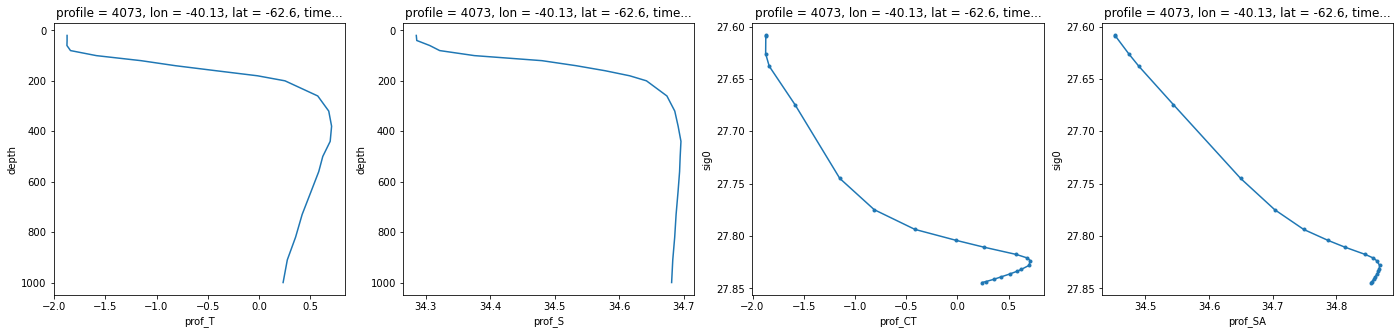

In [3]:
# load single class (just the Weddell One)
profiles = lp.load_single_class(classified_data_location, selected_class=myClass)

# plot random profile
pt.plot_profile(ploc, profiles.isel(profile=1400))

## Dimensionality reduction via PCA

### Carry out principal component expansion

load_and_preprocess.fit_and_apply_pca
load_and_preprocess.apply_scaling
load_and_preprocess.apply_scaling: using depth levels
Fitting PCA
0.9466043216836117
file_io.save_pca
plot_tools.plot_pca


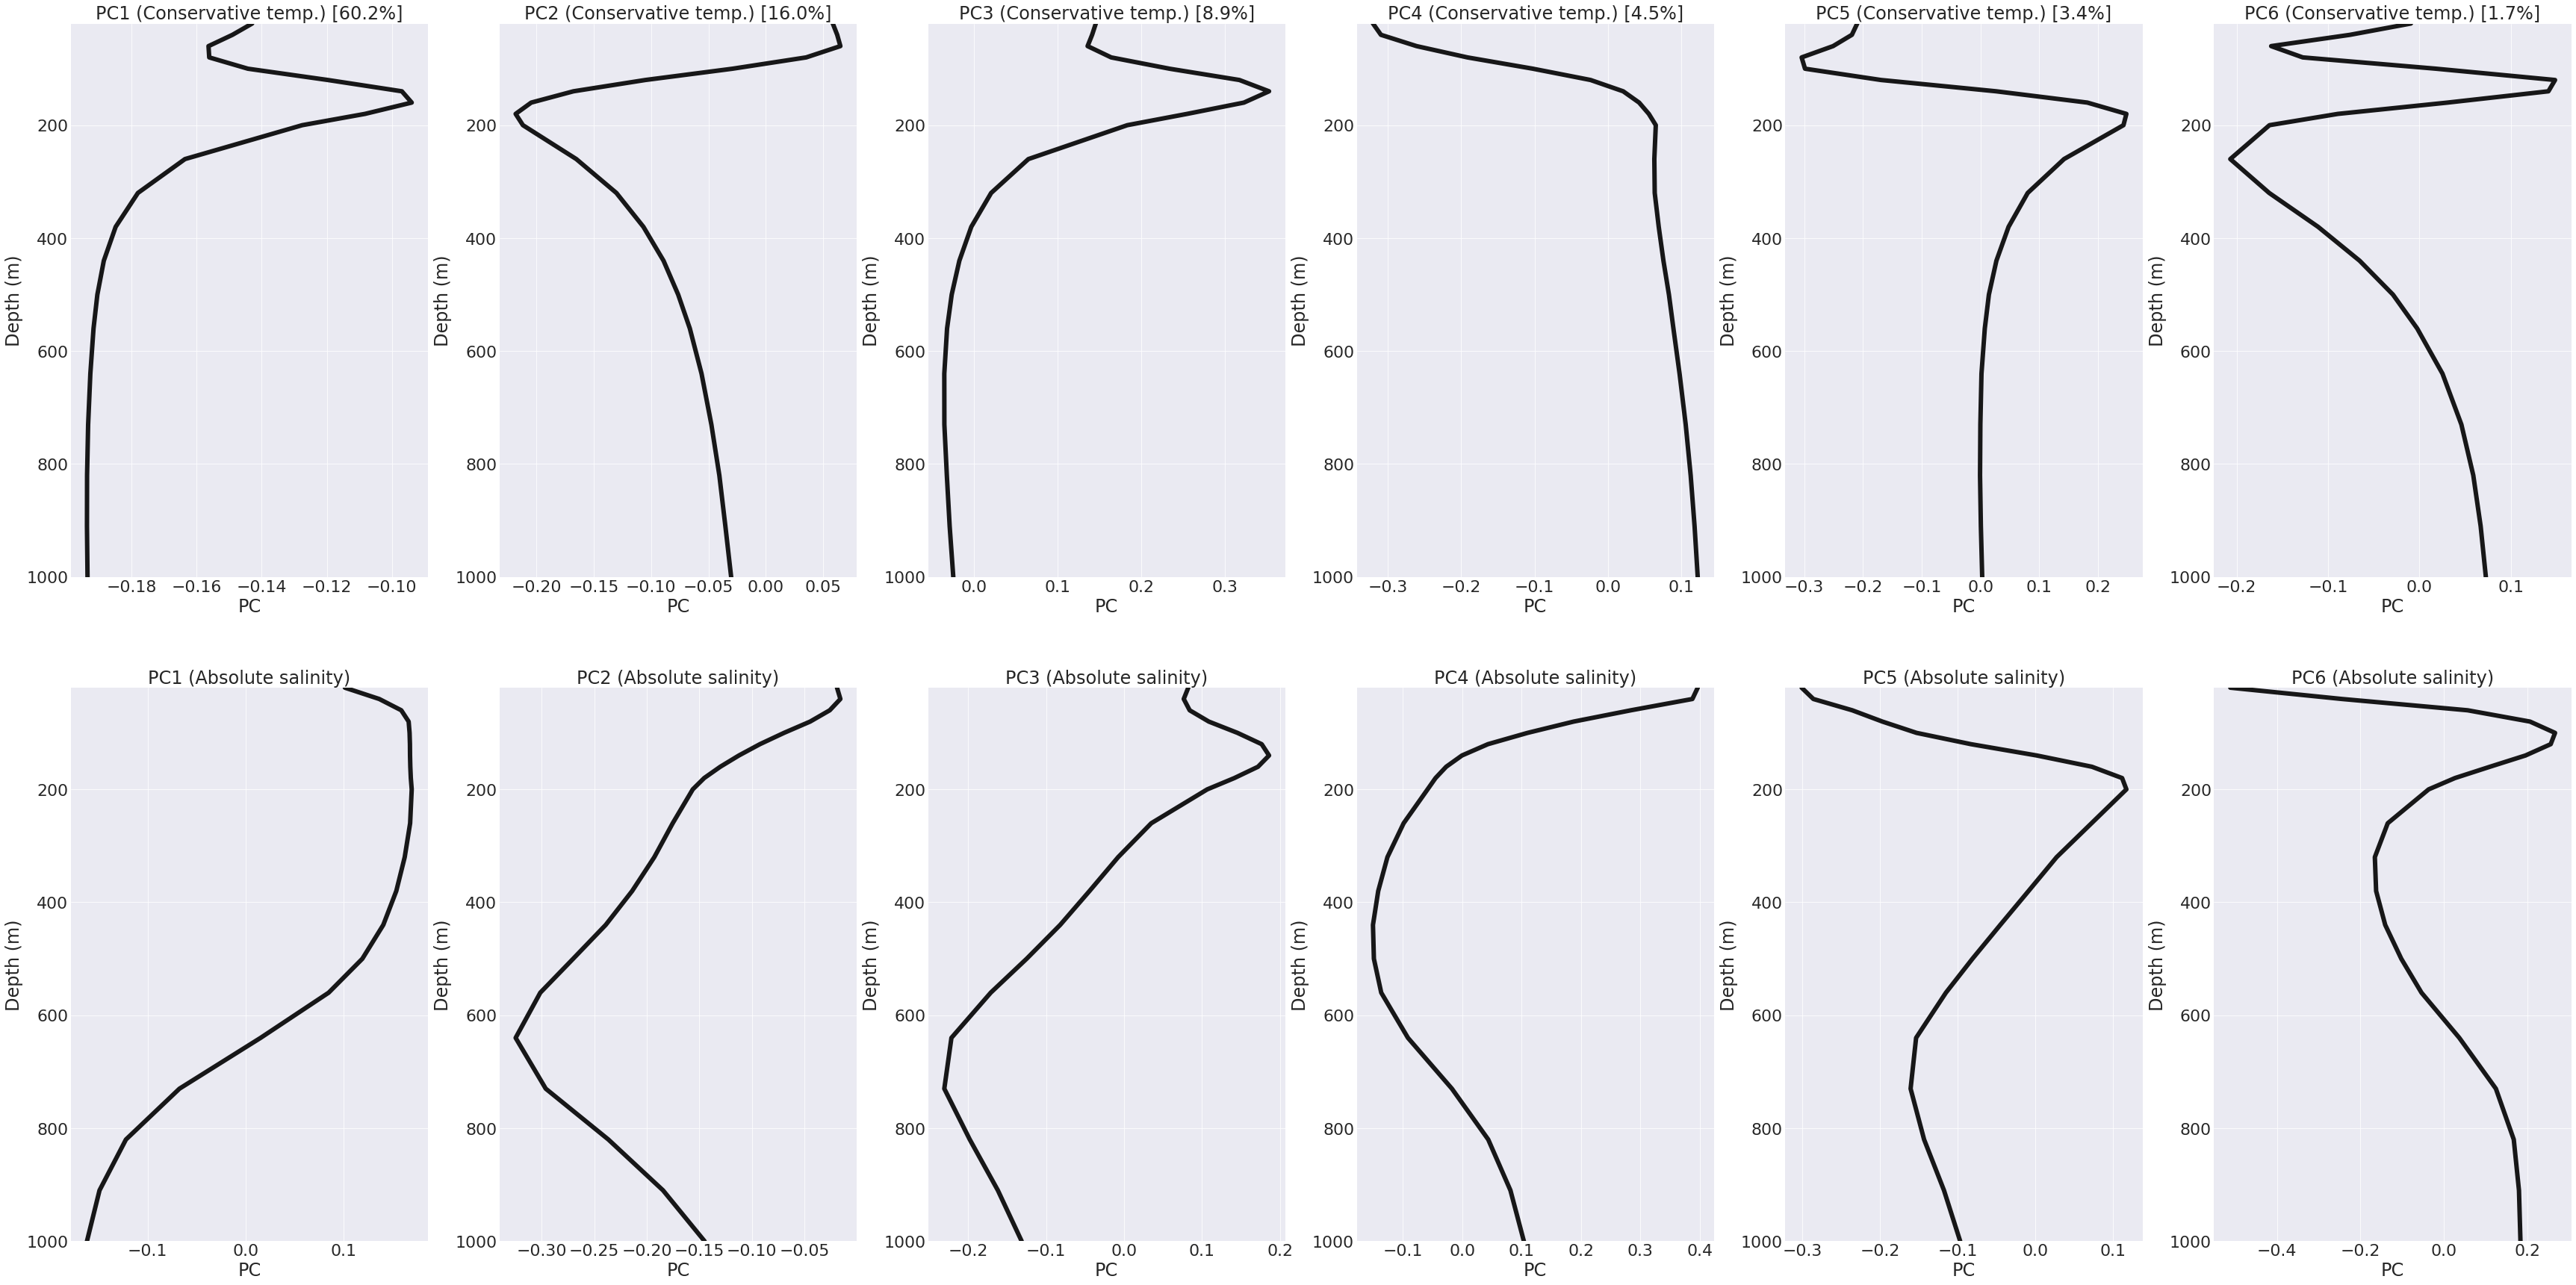

In [4]:
# if trained PCA already exists, load it
if os.path.isfile(pca_fname):
    pca = io.load_pca(pca_fname)
    Xtrans = lp.apply_pca(profiles, pca)
# otherwise, go ahead and train it
else:
    # apply PCA
    pca, Xtrans = lp.fit_and_apply_pca(profiles,
                                       number_of_pca_components=n_pca,
                                       train_frac=0.99)
    # save for future use
    io.save_pca(pca_fname, pca)

# plot PCA structure
pt.plot_pca_vertical_structure(ploc, profiles, pca, Xtrans)

### Examine pairplot of principal component coefficients

plot_tools.plot_pairs


<Figure size 1080x1080 with 0 Axes>

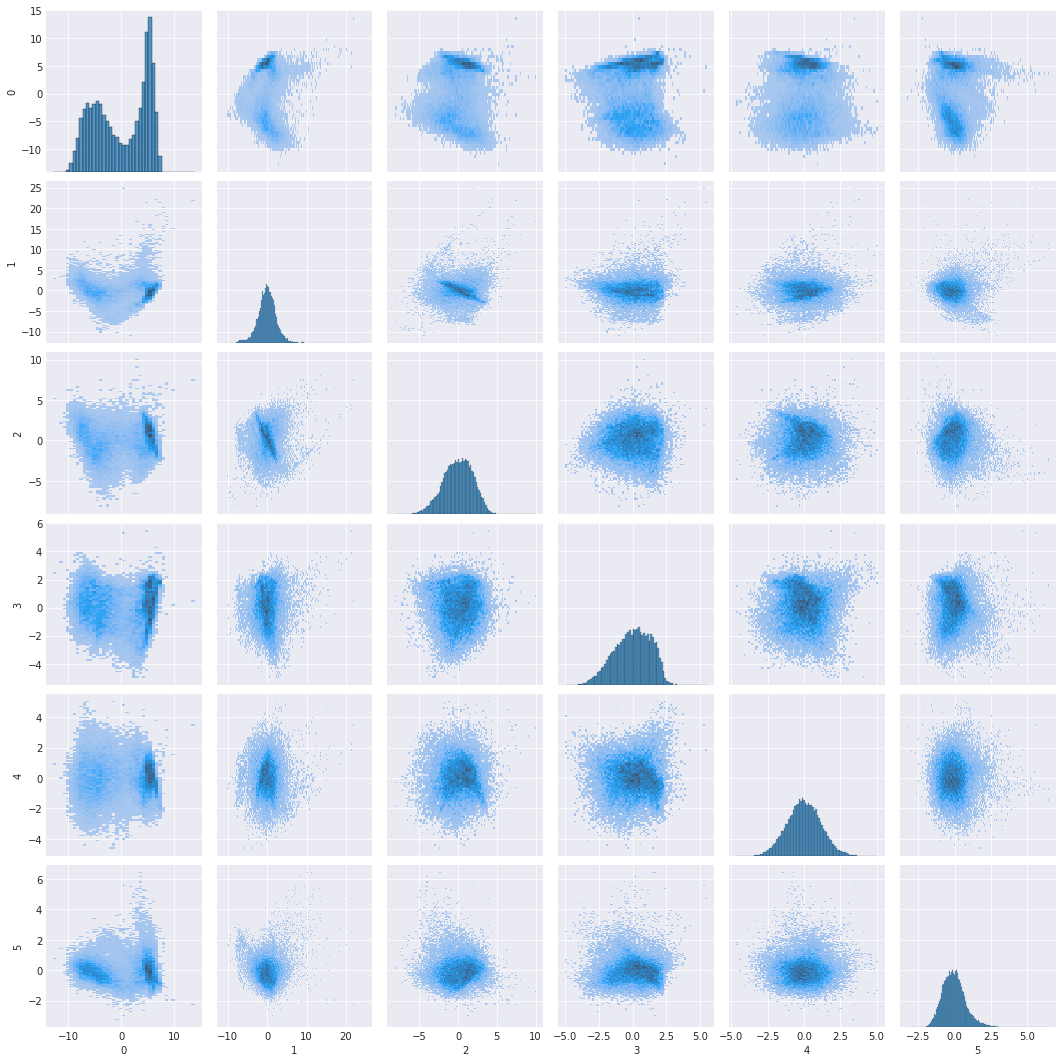

In [5]:
# pairplot of transformed variables
pt.plot_pairs(ploc, Xtrans, kind='hist', descr='pca')

### Determining the number of classes: statistical guidance

In [6]:
# calculate BIC and AIC
if getBIC==True:
    bic_mean, bic_std, aic_mean, aic_std = ba.calc_bic_and_aic(Xtrans, max_N)
    pt.plot_bic_scores(ploc, max_N, bic_mean, bic_std)
    pt.plot_aic_scores(ploc, max_N, aic_mean, aic_std)

## Classification analysis using GMM

### Profile classificaiton

In [7]:
# if GMM exists, load it. Otherwise, create it.
if os.path.isfile(gmm_fname):
    best_gmm = io.load_gmm(gmm_fname)
else:
    best_gmm = gmm.train_gmm(Xtrans, n_components_selected)
    io.save_gmm(gmm_fname, best_gmm)

# apply either loaded or created GMM
profiles = gmm.apply_gmm(profiles, Xtrans, best_gmm, n_components_selected)

# calculate class statistics
class_means, class_stds = gmm.calc_class_stats(profiles)

gmm.train_gmm
file_io.save_gmm
gmm.apply_gmm
gmm.calc_class_stats


### tSNE for visualisation

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


plot_tools.plot_tsne


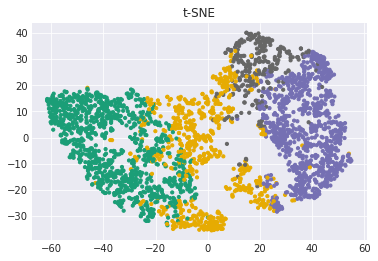

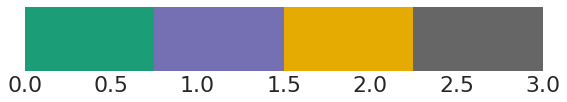

In [8]:
# fit and apply tsne
tSNE_data, colors_for_tSNE = lp.fit_and_apply_tsne(profiles, Xtrans)

# plot t-SNE with class labels
pt.plot_tsne(ploc+"tSNE/", colormap, tSNE_data, colors_for_tSNE)

## Analyze class properties

### Examine the Dataset

In [9]:
# simplify Dataset for plotting purposes
dfp = profiles
dfp = dfp.drop({'depth_highz','sig0_levs','prof_T','prof_S','ct_on_highz',
                'sa_on_highz','sig0_on_highz','ct_on_sig0','sa_on_sig0'})
dfp

<xarray.Dataset>
Dimensions:        (profile: 28397, depth: 21, CLASS: 4)
Coordinates:
  * profile        (profile) int64 13 14 15 16 ... 142282 142301 142320 142330
    lon            (profile) float64 ...
    lat            (profile) float64 ...
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] ...
    year           (profile) int64 ...
    month          (profile) int64 ...
  * CLASS          (CLASS) int64 0 1 2 3
Data variables:
    prof_date      (profile) float64 ...
    prof_YYYYMMDD  (profile) float64 ...
    prof_HHMMSS    (profile) float64 ...
    sig0           (profile, depth) float64 ...
    prof_SA        (profile, depth) float64 33.58 33.82 34.19 ... 34.9 34.9 34.9
    prof_CT        (profile, depth) float64 -0.1931 -0.8729 ... 1.535 1.466
    label          (profile) int64 3 2 0 2 2 1 3 1 3 2 2 ... 0 0 0 0 0 0 0 0 0 0
    posteriors     (profile, CLASS) float64 3.789e-27 5.79e-26 ... 6.702e-10

### Examine view of classes in PCA space

This is a projection of the full 6D PCA space in which the clustering occurs

plot_tools.plot_pca2D


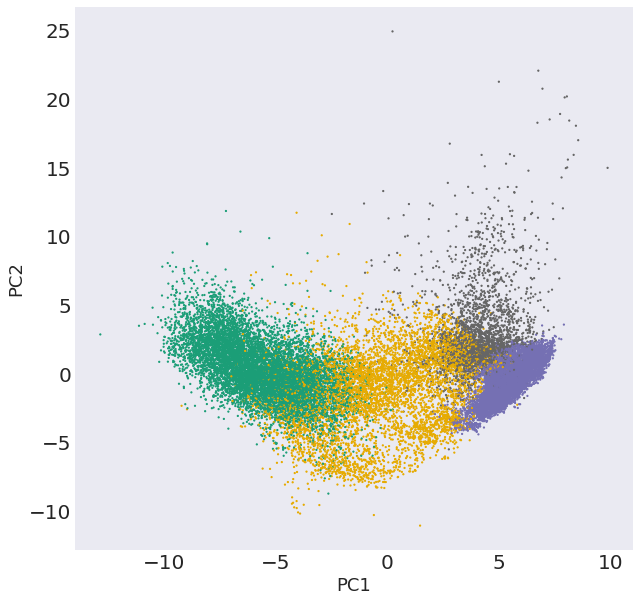

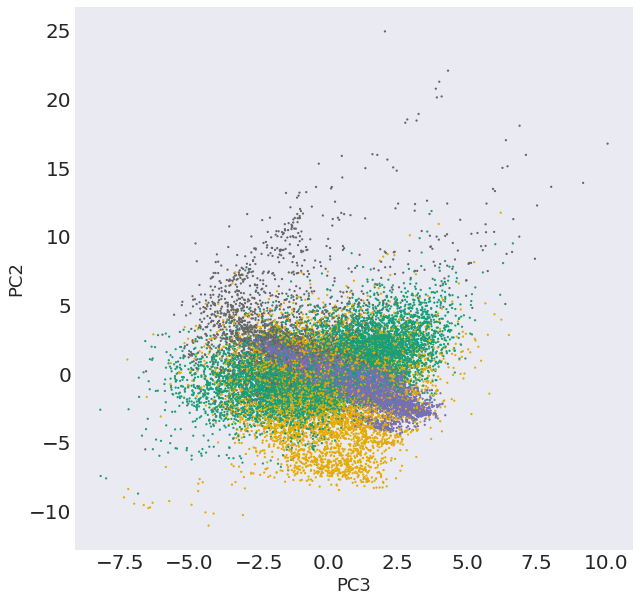

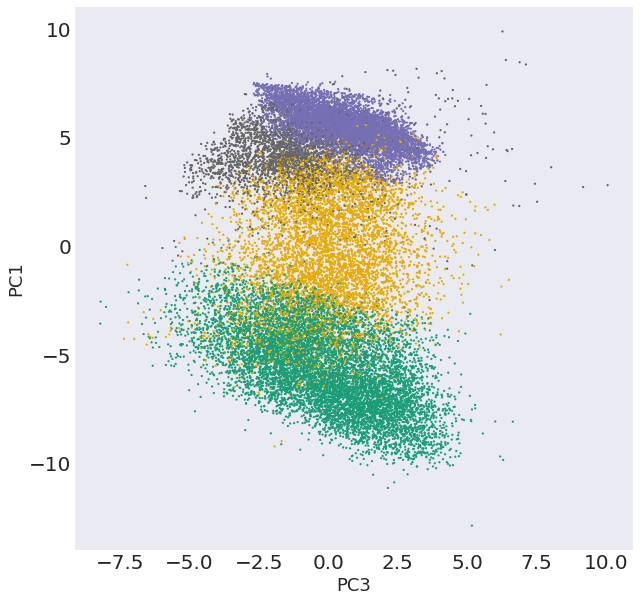

In [10]:
# plot 3D pca structure (now with class labels)
#pt.plot_pca3D(ploc, colormap, dfp, Xtrans, frac=0.90, withLabels=True)

# plot 2D view of PCA space
pt.plot_pca2D(ploc, colormap, dfp, Xtrans, pca, best_gmm, frac=0.90, withLabels=True, fs=20)

### Plot the vertical structure of the classes (temperature, salinity, and density in the top 1000m)

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

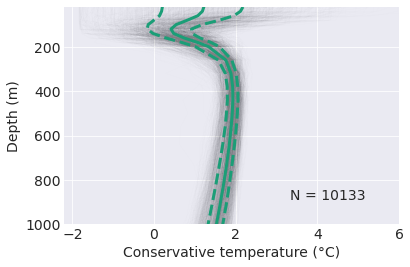

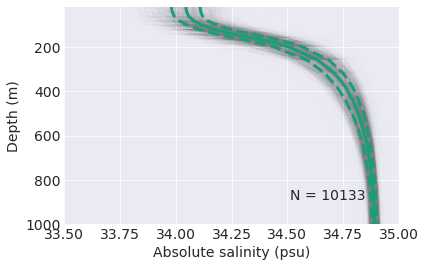

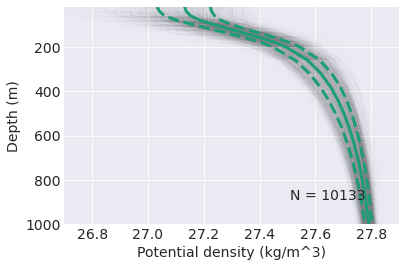

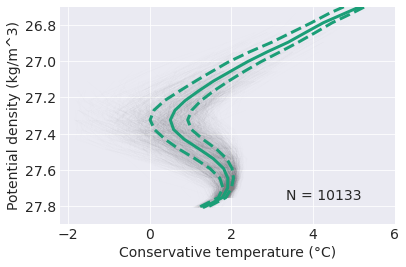

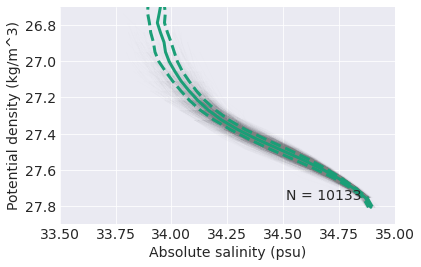

plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

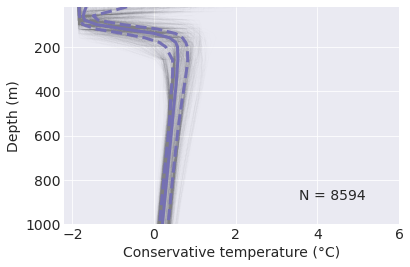

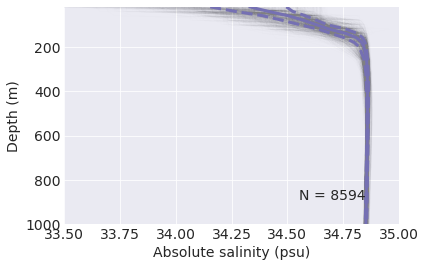

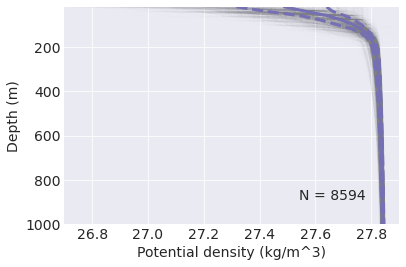

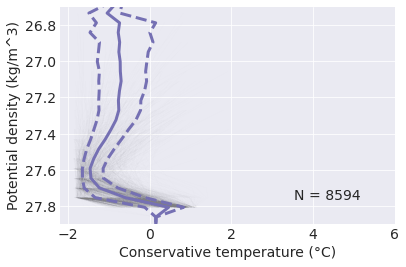

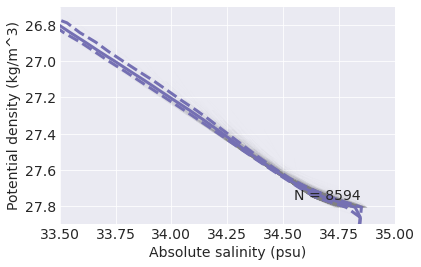

plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

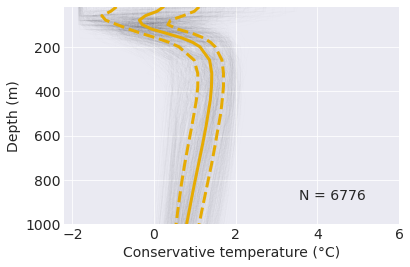

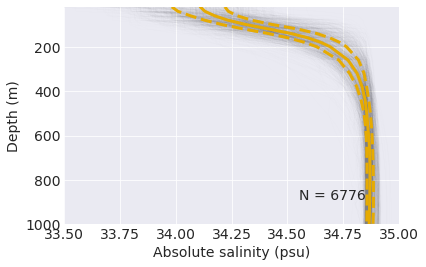

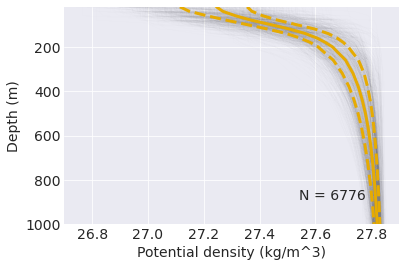

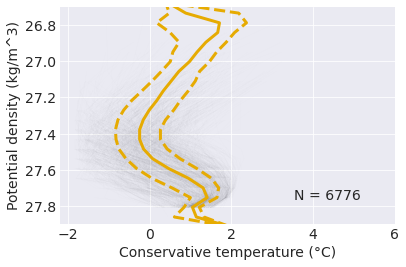

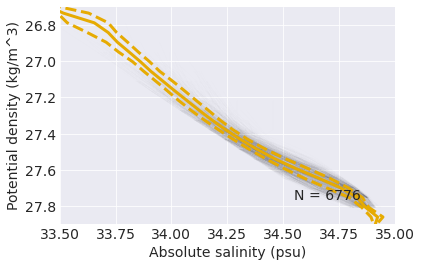

plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

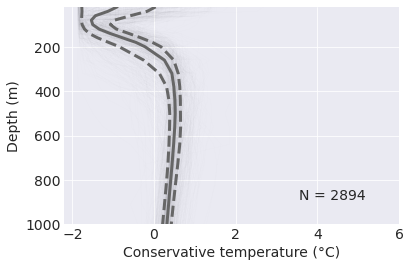

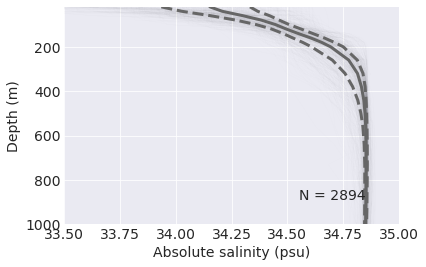

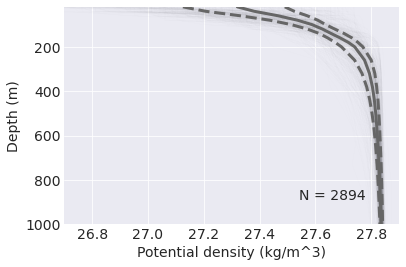

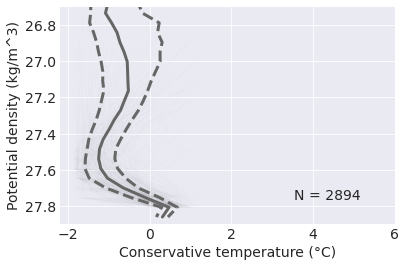

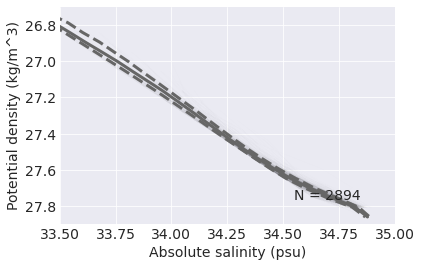

In [11]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, profiles, n_components_selected, colormap,
                                  zmin=zmin, zmax=zmax,
                                  Tmin=Trange[0], Tmax=Trange[1],
                                  Smin=Srange[0], Smax=Srange[1],
                                  sig0min = 26.7, sig0max = 27.9,
                                  frac=0.18)

### Plot the vertical structure of the classes (temperature, salinity, and density in the top 400m)

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

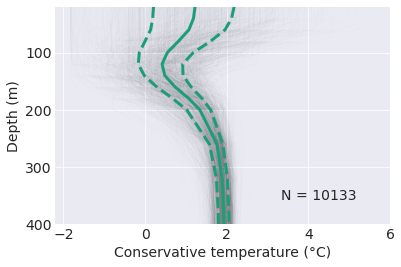

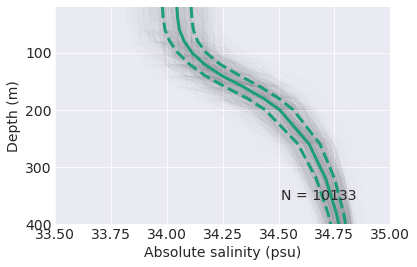

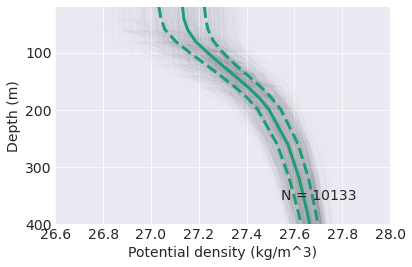

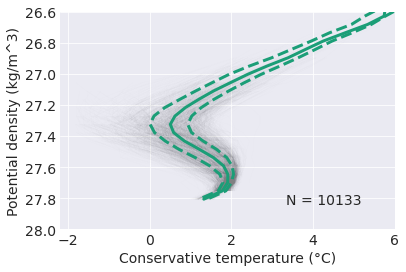

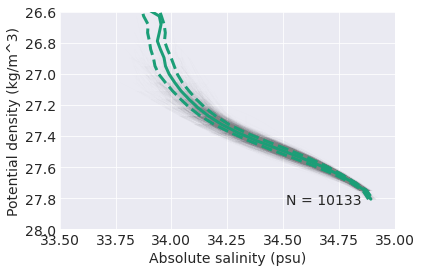

plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

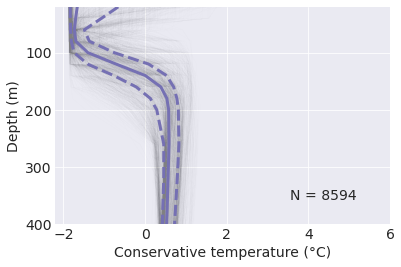

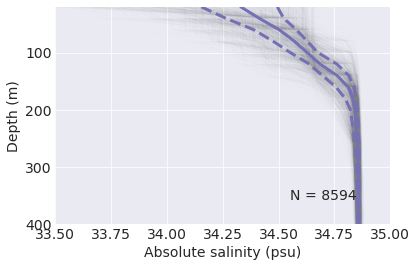

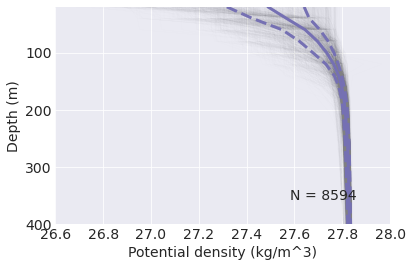

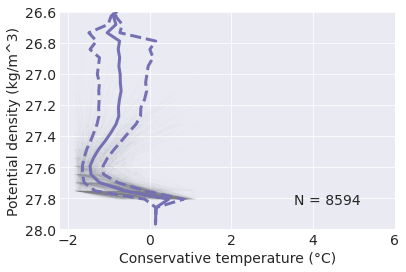

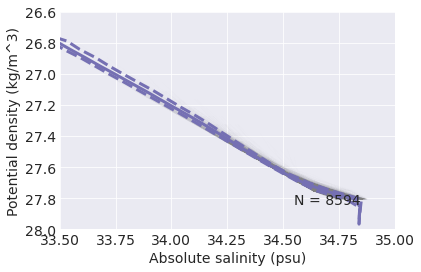

plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

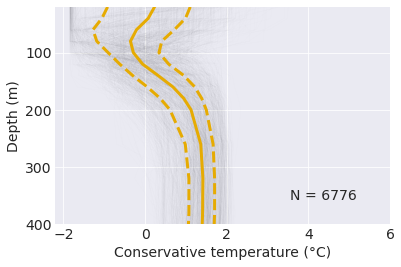

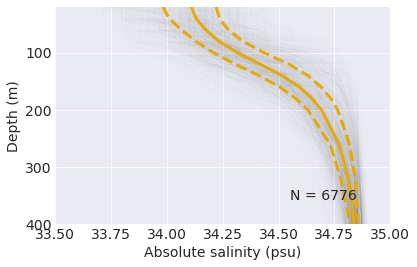

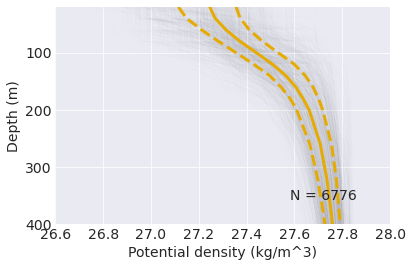

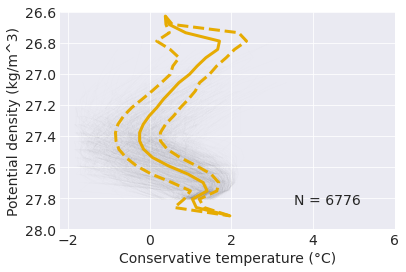

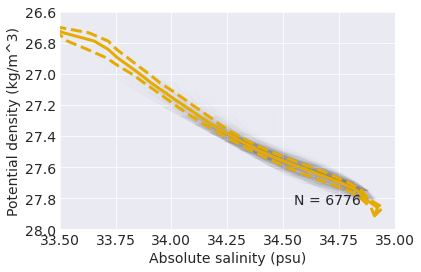

plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

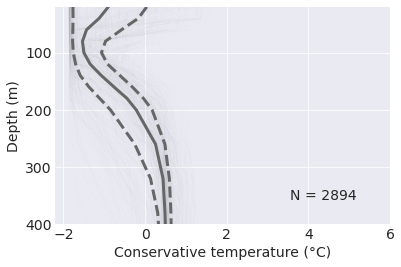

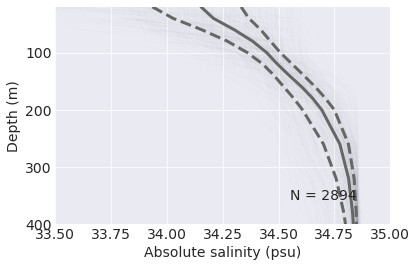

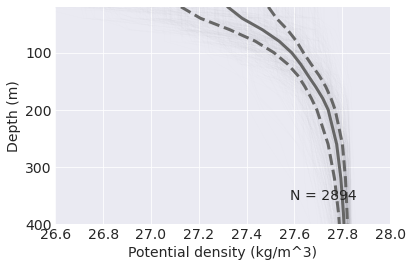

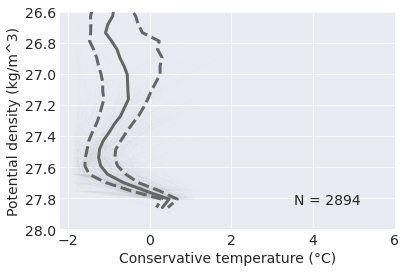

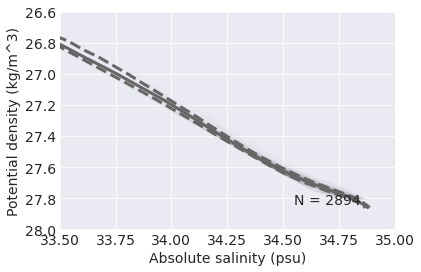

In [12]:
pt.plot_class_vertical_structures(ploc, profiles, n_components_selected, colormap,
                                  zmin=zmin, zmax=400,
                                  Tmin=Trange[0], Tmax=Trange[1],
                                  Smin=Srange[0], Smax=Srange[1],
                                  sig0min=sig0range[0], sig0max=sig0range[1],
                                  frac=0.18, description='top400m')

### Mean class properties in T-S space

plot_tools.plot_TS_withMeans


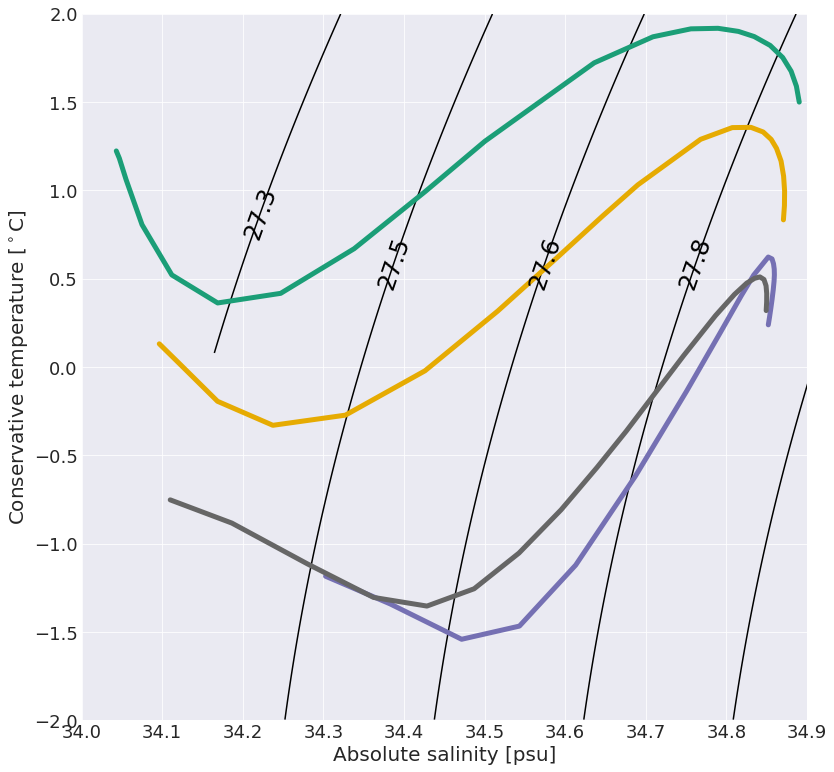

In [13]:
# TS diagram just showing the mean values
pt.plot_TS_withMeans(ploc, class_means, class_stds, n_components_selected, colormap,
                     PTrange=(-2, 2), SPrange=(34.0, 34.9))

plot_tools.plot_TS_bytime


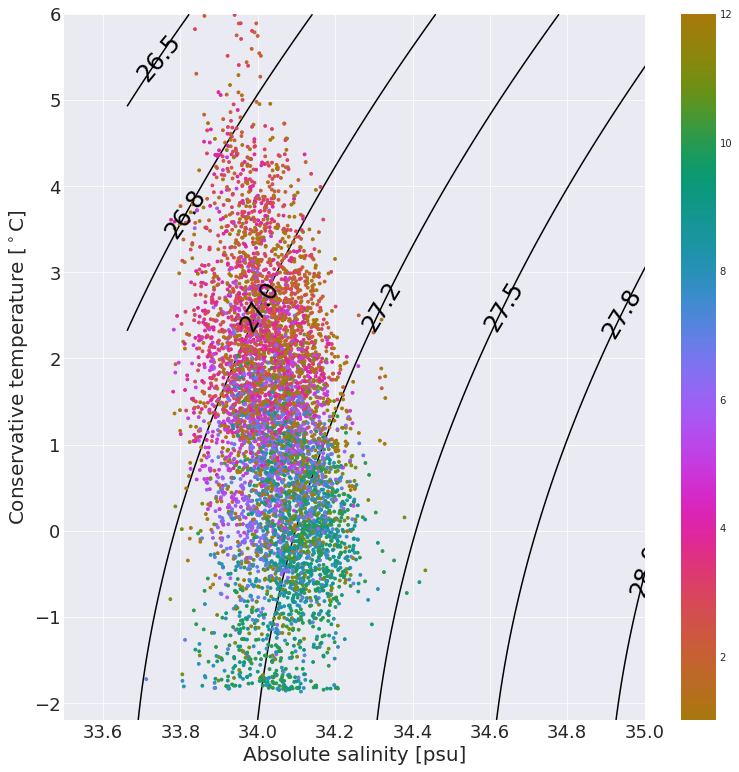

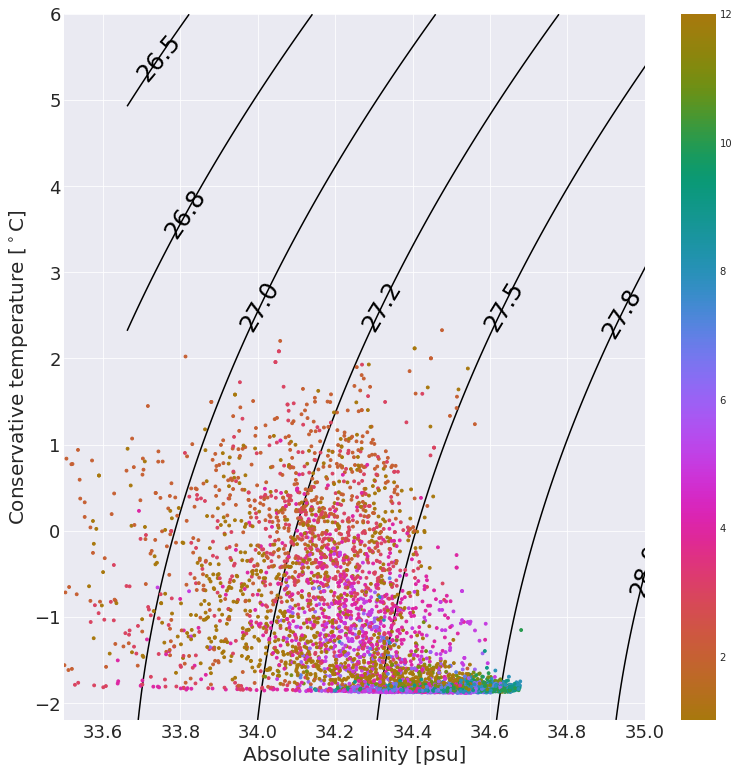

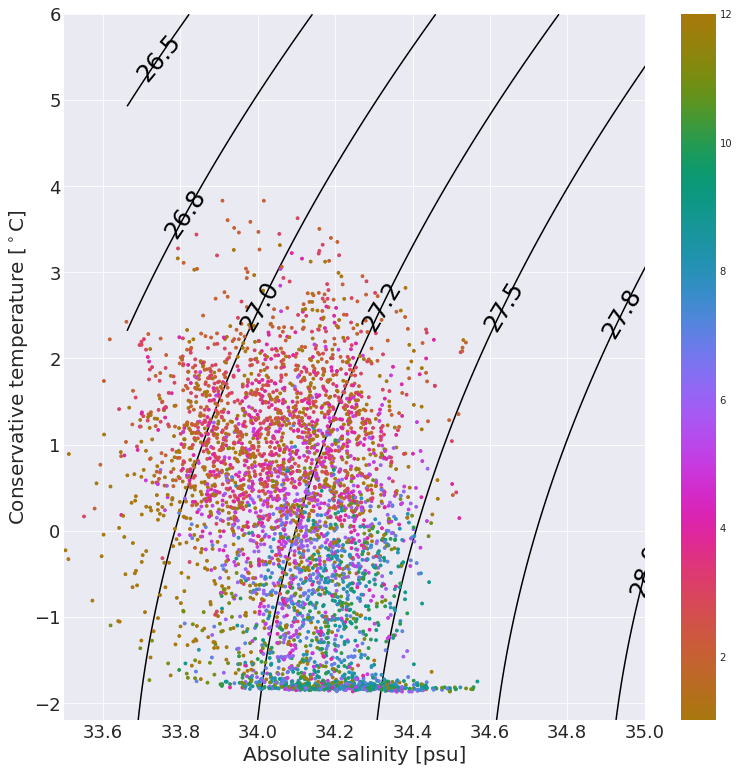

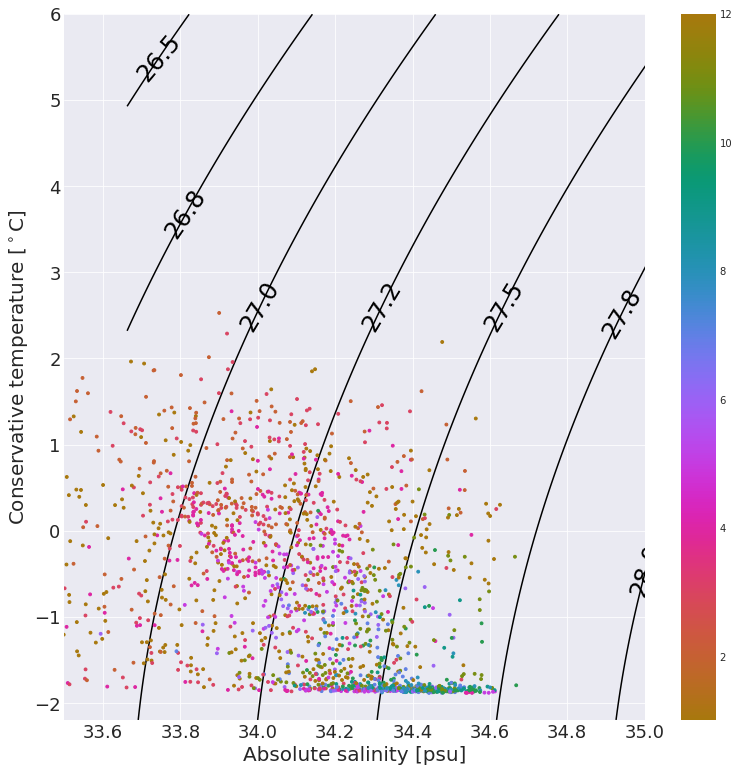

In [14]:
pt.plot_TS_bytime(ploc, dfp, n_components_selected,
                   descrip='', PTrange=Trange, SPrange=Srange,
                   lon = -20, lat = -65, rr = 0.60, timeShading='month')

### Calculate mixed layer depth, min/max values, and i-metric

In [15]:
# Calc and plot dynamic height, N2, mixed layer depth, etc.
dfp = density.calc_dynamic_height(dfp)
dfp = density.calc_Nsquared(dfp)
dfp = density.calc_mixed_layer_depth(dfp)

# Calc Tmin, Tmax, Smin, Smax
dfp['Tmin'] = dfp.prof_CT.min(dim='depth')
dfp['Tmin_depth'] = dfp.prof_CT.idxmin(dim='depth', skipna=True)
dfp['Tmax'] = dfp.prof_CT.max(dim='depth')
dfp['Tmax_depth'] = dfp.prof_CT.idxmax(dim='depth', skipna=True)
dfp['Smin'] = dfp.prof_SA.min(dim='depth')
dfp['Smin_depth'] = dfp.prof_SA.idxmin(dim='depth', skipna=True)
dfp['Smax'] = dfp.prof_SA.max(dim='depth')
dfp['Smax_depth'] = dfp.prof_SA.idxmax(dim='depth', skipna=True)
dfp['sig0min'] = dfp.sig0.min(dim='depth')
dfp['sig0max'] = dfp.sig0.max(dim='depth')

# i-metric calculation
dfp['imetric'] = gmm.calc_i_metric(profiles).i_metric

density.calc_dynamic_height
density.calc_Nsquared
density.calc_mixed_layer depth
NOTE: must call density.calc_Nsquared first
gmm.calc_i_metric


## tSNE alternative plots

### Tmax

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


plot_tools.plot_tsne


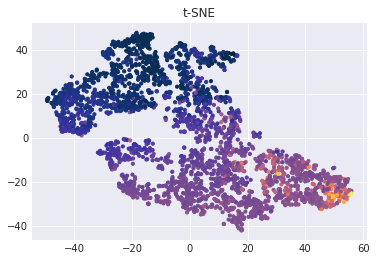

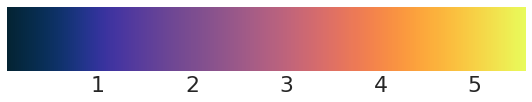

In [16]:
df1D = dfp.isel(depth=0)
myVar = "Tmax"
tSNE_data, colors_for_tSNE = lp.fit_and_apply_tsne(df1D, Xtrans, var_to_plot=myVar)
pt.plot_tsne(ploc+"tSNE/", cmocean.cm.thermal, tSNE_data, colors_for_tSNE, describe=myVar)

### Dynamic height

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


plot_tools.plot_tsne


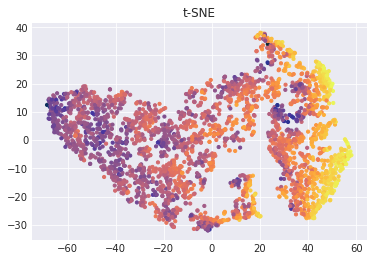

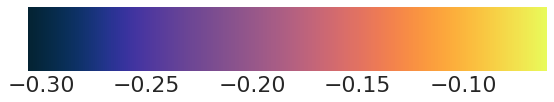

In [17]:
myVar = "dyn_height"
tSNE_data, colors_for_tSNE = lp.fit_and_apply_tsne(df1D, Xtrans, var_to_plot=myVar)
pt.plot_tsne(ploc+"tSNE/", cmocean.cm.thermal, tSNE_data, colors_for_tSNE, describe=myVar)

### MLD

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


plot_tools.plot_tsne


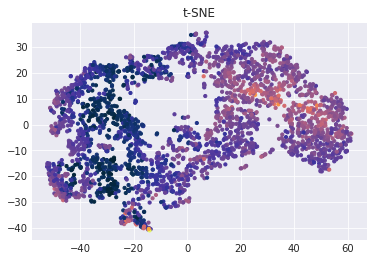

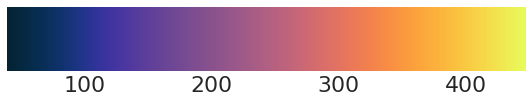

In [18]:
myVar = "mld"
tSNE_data, colors_for_tSNE = lp.fit_and_apply_tsne(df1D, Xtrans, var_to_plot=myVar)
pt.plot_tsne(ploc+"tSNE/", cmocean.cm.thermal, tSNE_data, colors_for_tSNE, describe=myVar)

### imetric

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


plot_tools.plot_tsne


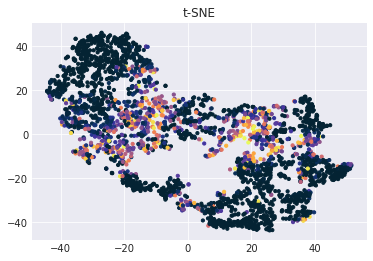

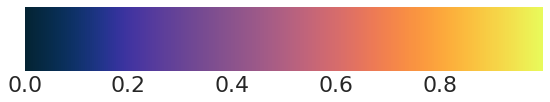

In [19]:
myVar = "imetric"
tSNE_data, colors_for_tSNE = lp.fit_and_apply_tsne(df1D, Xtrans, var_to_plot=myVar)
pt.plot_tsne(ploc+"tSNE/", cmocean.cm.thermal, tSNE_data, colors_for_tSNE, describe=myVar)

### Save to disk, to be analyzed further in notebook 3

In [21]:
# Save to disk for analysis
if saveOutput==True:
    profiles.to_netcdf("weddell_classified_n4_withSigmaValues.nc")
    dfp.to_netcdf("weddell_classified_n4.nc")